# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
)
from train_binary_cl import seed_worker
from config import *

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt")
subset_test_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_test_nt.txt")
subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_nt.txt")

with open(subset_train_nt, "rb") as fp:  # Unpickling
    list_train = pickle.load(fp)
    
with open(subset_test_nt, "rb") as fp:  # Unpickling
    list_test = pickle.load(fp)
    
with open(subset_val_nt, "rb") as fp:  # Unpickling
    list_val = pickle.load(fp)

/tmp/ipykernel_265856/1354800447.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))


# Esecuzione data loader train

In [66]:
vc_train = df_nt[df_nt.couples.isin(list_train)].interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

pos_multipliers = {15:0.2, 
                   50:0.2, 
                   100:0.1, 
                   150:0.1, 
                   10_000_000: 0.4}
neg_multipliers = pos_multipliers

policies_train = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
    
    
dataset_train = RNADataset(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_train_nt,
        augment_policies=policies_train,
)

In [68]:
n_epochs = 1
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/148427 [00:00<?, ?it/s]

In [69]:
# plot_sample(sample, plot_interaction_negatives=True)

In [70]:
df_len.label.value_counts()

p    148694
n    148160
Name: label, dtype: int64

In [71]:
df_len.sort_values('length').head(500).label.value_counts()

n    274
p    226
Name: label, dtype: int64

In [79]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

/tmp/ipykernel_265856/2040448453.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (float(df_len.sort_values('length').quantile(0.2))/6)/80


1.2145833333333333

In [73]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

/tmp/ipykernel_265856/2118712018.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (float(df_len.sort_values('length').quantile(0.5))/6)/80


3.8541666666666665

In [74]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.01

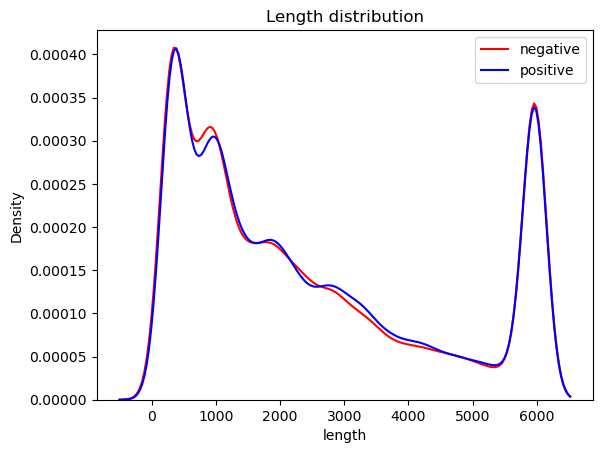

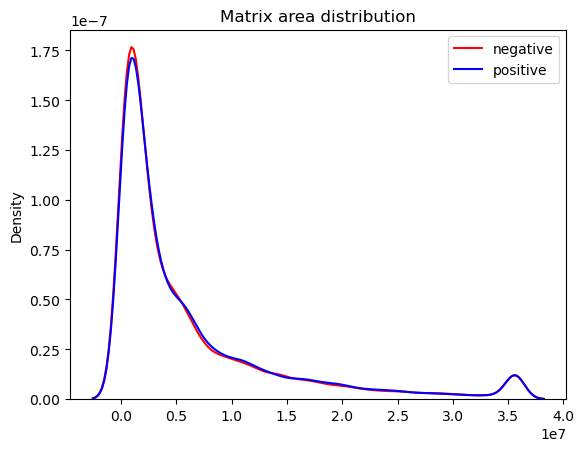

In [75]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

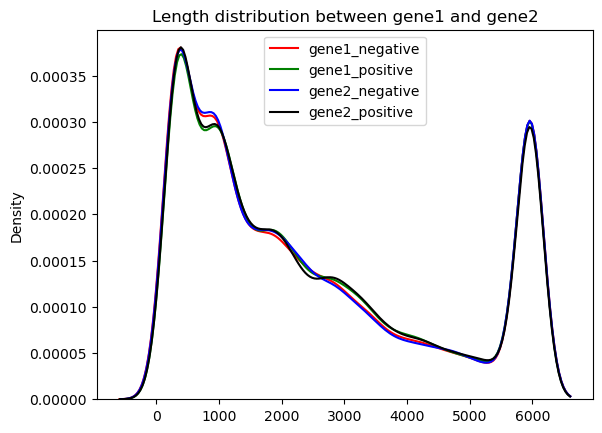

In [76]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [77]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

n    14055
p    12116
Name: label, dtype: int64


p    44376
n    43541
Name: label, dtype: int64


In [6]:
dataset_train = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=subset_train_nt,
    augment_policies=policies_train,
    data_dir = os.path.join(embedding_dir, '32'),
)

all_couples = set(df_nt.couples_id)

augment_list = create_augment_list(dataset_train, all_couples)

dataset_train = HFDataset(augment_list)

batch_size = 32

sampler_train = torch.utils.data.RandomSampler(dataset_train)

data_loader_train = HFDataLoader(dataset_train, batch_size=batch_size, 
                                 sampler=sampler_train, drop_last=False,
                                 collate_fn = utils.collate_fn_hf, num_workers=10)

start_time = time.time()

i = 0
for s, targets in tqdm(data_loader_train):
    i += 1
    if i == 100:
        break
    
end_time = time.time()

print('min:', (end_time-start_time)/60)

  0%|          | 0/3696 [00:00<?, ?it/s]

min: 2.3028923869132996


In [ ]:
policies = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
  

dataset_train = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=subset_train_nt,
    augment_policies=policies,
    data_dir = os.path.join(embedding_dir, '32'),
)

sampler_train = torch.utils.data.RandomSampler(dataset_train)

data_loader_train = DataLoader(dataset_train, 32,
                             sampler=sampler_train, drop_last=False,
                             collate_fn=utils.collate_fn_nt,
                             num_workers=2,)

start_time = time.time()

i = 0
for s, targets in tqdm(data_loader_train, total = len(data_loader_train)):
    i += 1
    if i == 100:
        break
    
end_time = time.time()

print('min:', (end_time-start_time)/60)

# Validation set 

In [4]:
vc_val = df_nt[df_nt.couples.isin(list_val)].interacting.value_counts()
assert vc_val[True]>vc_val[False]
unbalance_factor = 1 - (vc_val[True] - vc_val[False]) / vc_val[True]

pos_multipliers = {10_000_000:1.,}
neg_multipliers = pos_multipliers

policies_val = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]

dataset_val = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=subset_val_nt,
    augment_policies=policies_val,
    data_dir = os.path.join(embedding_dir, '32'),
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

In [ ]:
g = torch.Generator()
g.manual_seed(0)
data_loader_val = DataLoader(dataset_val, 32,
                             sampler=sampler_val, drop_last=False,
                             collate_fn=utils.collate_fn_nt,
                             num_workers=10,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in tqdm(data_loader_val, total = len(data_loader_val)):
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [24]:
df_len.label.value_counts()

p    24096
n    21824
Name: label, dtype: int64

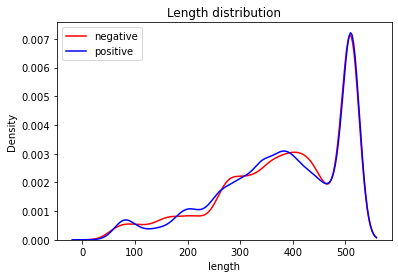

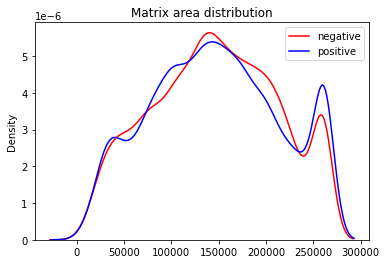

In [25]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

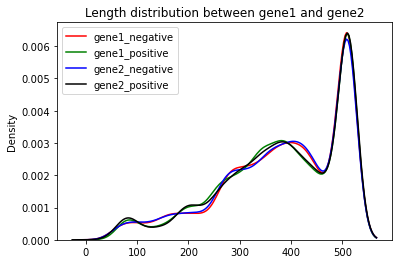

In [26]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

# Test 

In [29]:
pos_width_multipliers_test = pos_width_multipliers
pos_height_multipliers_test = pos_width_multipliers_test

neg_width_windows_test = neg_width_windows
neg_height_windows_test = neg_width_windows_test

assert np.round(sum(pos_width_multipliers_test.values()), 4) == np.round(sum(neg_width_windows_test.values()), 4) == 1    


policies_test = [
        EasyPosAugment(
            per_sample=2,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        EasyNegAugment(
            per_sample=0.04,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        HardPosAugment(
            per_sample=0.1,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        HardNegAugment(
            per_sample=0.04,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers_val,
        height_multipliers=pos_height_multipliers_val,
    ),
]

dataset_test = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt"),
            augment_policies=policies_test,
)
sampler_test = torch.utils.data.SequentialSampler(dataset_test)

In [30]:
g = torch.Generator()
g.manual_seed(0)
data_loader_test = DataLoader(dataset_test, 32,
                             sampler=sampler_test, drop_last=False,
                             collate_fn=utils.collate_fn,
                             num_workers=10,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in tqdm(data_loader_test, total = len(data_loader_test)):
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/1463 [00:00<?, ?it/s]

In [31]:
df_len.label.value_counts()

n    46900
p    46688
Name: label, dtype: int64

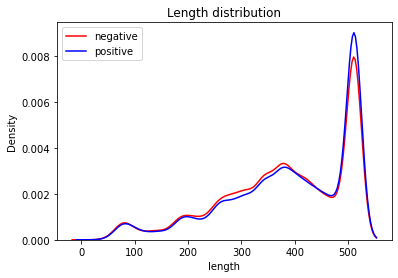

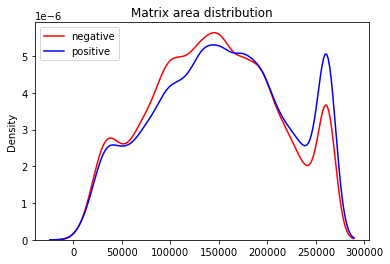

In [32]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()